# Task 3: LIME - Local Interpretable Model-agnostic Explanations

In this task, we use LIME to explain the predictions of a deep neural network (ResNet50) on images from the `img` folder. LIME helps us understand which parts of an image contribute most to the model's decision by perturbing the input and observing the changes in output.

In [44]:
# Import required libraries
import os
import numpy as np
import torch
from torchvision import models, transforms
from PIL import Image
import matplotlib.pyplot as plt
from lime import lime_image
from skimage.segmentation import mark_boundaries
import lime

In [45]:
# Load images from the img folder
img_folder = 'img' if os.path.exists('img') else '../img'
img_files = [os.path.join(img_folder, f) for f in os.listdir(img_folder) if f.endswith('.JPEG')]
print(f'Found {len(img_files)} images.')

# Preprocessing for ResNet50
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

def load_image(img_path):
    img = Image.open(img_path).convert('RGB')
    return img

Found 10 images.


In [46]:
# Load pretrained ResNet50 model
model = models.resnet50(pretrained=True)
model.eval()

# Load ImageNet class labels
import urllib.request
LABELS_URL = 'https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt'
with urllib.request.urlopen(LABELS_URL) as f:
    class_names = [line.strip() for line in f.readlines()]
    class_names = [c.decode() if isinstance(c, bytes) else c for c in class_names]
print('Loaded', len(class_names), 'class labels')

c:\Users\hassa\anaconda3\envs\tml_a4\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\hassa\anaconda3\envs\tml_a4\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loaded 1000 class labels


In [47]:
# Define prediction function for LIME
import torch.nn.functional as F

def batch_predict(images):
    model.eval()
    batch = torch.stack([preprocess(Image.fromarray(img)) for img in images], dim=0)
    with torch.no_grad():
        logits = model(batch)
        probs = F.softmax(logits, dim=1)
    return probs.cpu().numpy()

# Test prediction on a sample image
sample_img = np.array(load_image(img_files[0]).resize((224, 224)))
preds = batch_predict([sample_img])
print('Top-5 predicted classes:')
for i in preds[0].argsort()[-1:-6:-1]:
    print(f'{class_names[i]}: {preds[0][i]:.3f}')

Top-5 predicted classes:
goldfish: 0.798
tench: 0.197
barracouta: 0.002
puffer: 0.002
rock beauty: 0.001


100%|██████████| 500/500 [00:13<00:00, 37.61it/s]

100%|██████████| 500/500 [00:17<00:00, 27.98it/s]

100%|██████████| 500/500 [00:24<00:00, 20.52it/s]

100%|██████████| 500/500 [00:22<00:00, 22.47it/s]

100%|██████████| 500/500 [00:13<00:00, 37.72it/s]

100%|██████████| 500/500 [00:19<00:00, 25.47it/s]

100%|██████████| 500/500 [00:21<00:00, 22.84it/s]

100%|██████████| 500/500 [00:32<00:00, 15.55it/s]

100%|██████████| 500/500 [00:28<00:00, 17.60it/s]

100%|██████████| 500/500 [00:12<00:00, 39.85it/s]



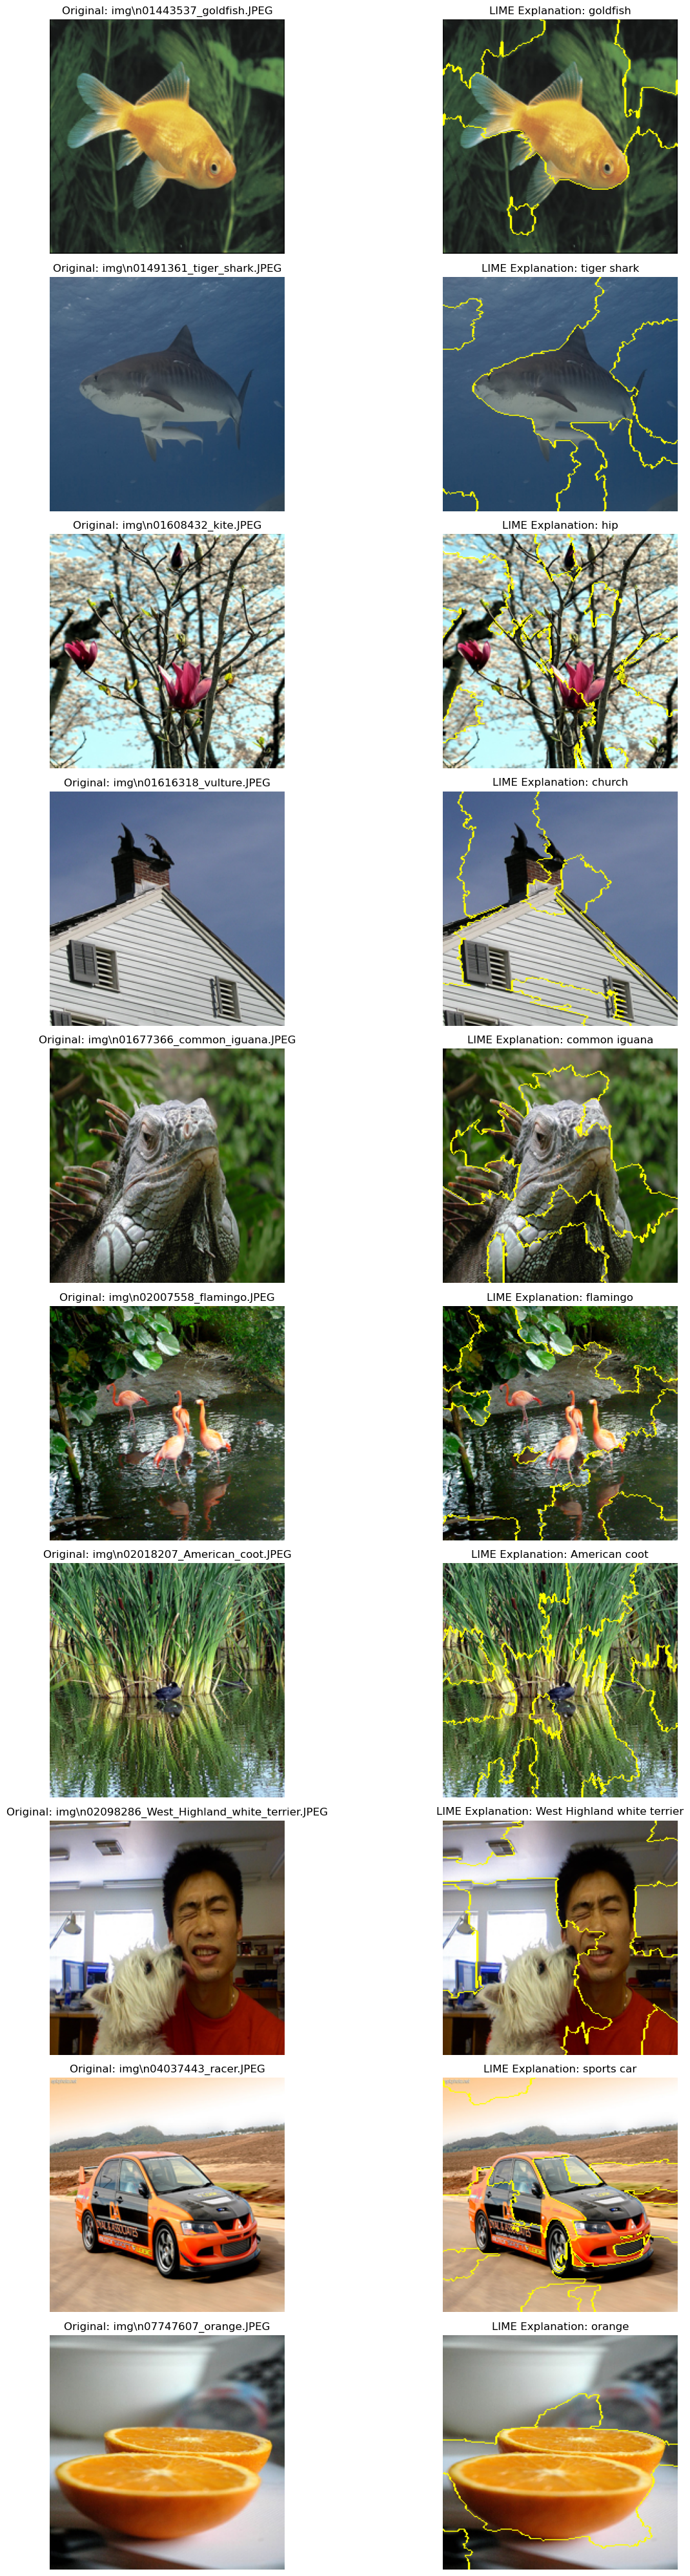

In [48]:
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt
import numpy as np

# Initialize LIME explainer
explainer = lime_image.LimeImageExplainer()

# Adjust layout for clearer viewing
plt.figure(figsize=(15, 4 * len(img_files)))

for i, img_path in enumerate(img_files):
    # Load and preprocess image
    img = load_image(img_path).resize((224, 224))
    img_np = np.array(img)

    # Run LIME
    explanation = explainer.explain_instance(
        img_np,
        batch_predict,
        top_labels=1,
        hide_color=0,
        num_samples=500  # or 1000 based on your choice
    )

    top_label = explanation.top_labels[0]
    img_expl, mask = explanation.get_image_and_mask(
        top_label,
        positive_only=True,
        num_features=15,
        hide_rest=False
    )

    # Show original and explanation side-by-side
    plt.subplot(len(img_files), 2, 2 * i + 1)
    plt.imshow(img_np)
    plt.title(f'Original: {img_path.split("/")[-1]}')
    plt.axis('off')

    plt.subplot(len(img_files), 2, 2 * i + 2)
    plt.imshow(mark_boundaries(img_expl, mask))
    plt.title(f'LIME Explanation: {class_names[top_label]}')
    plt.axis('off')

plt.tight_layout()
plt.show()


In [2]:
import pickle

# List of required image keys (use the correct names as per instructions)
key_names = [
    'West_Highland_white_terrier', 'American_coot', 'racer', 'flamingo', 'kite',
    'goldfish', 'tiger_shark', 'vulture', 'common_iguana', 'orange'
]

# Example: Use the same parameters for all images (customize if needed)
lime_params = {
    'top_labels': 1,
    'hide_color': 0,
    'num_features': 15,
    'num_samples': 500
}

# Create the dictionary for all images
all_params = {k: lime_params.copy() for k in key_names}

# Save to pickle file
with open('explain_params.pkl', 'wb') as f:
    pickle.dump(all_params, f)
print('Saved explain_params.pkl with LIME parameters for all required images.')

Saved explain_params.pkl with LIME parameters for all required images.


In [3]:
# Submit the explain_params.pkl file to the server (replace YOUR_TOKEN_HERE with your token)
import requests
response = requests.post(
    "http://34.122.51.94:9091/lime",
    files={"file": open("explain_params.pkl", "rb")},
    headers={"token": "61729223"}
)
try:
    print(response.json())
except Exception:
    print("Raw response:", response.text)

c:\Users\hassa\anaconda3\envs\tml_a4\Lib\site-packages\requests\__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


{'avg_iou': 0.2892533786549757, 'avg_time': 2.4262773036956786}


## Task 3 Report: LIME - Local Interpretable Model-agnostic Explanations
 
### Approach
For this task, we used the LIME (Local Interpretable Model-agnostic Explanations) framework to interpret the predictions of a pretrained ResNet50 model on 10 given ImageNet images. The main steps were:
 
1. **Image Loading & Preprocessing:**  
   All 10 images were loaded from the `img` folder and resized to 224x224 pixels to match the input requirements of ResNet50. Standard normalization was applied.
 
2. **Model & Class Labels:**  
   The pretrained ResNet50 model from torchvision was used. ImageNet class labels were loaded for interpretation of predictions.
 
3. **Prediction Function:**  
   A batch prediction function was defined to preprocess images and return class probabilities using the model.
 
4. **LIME Explanation:**  
   For each image, the `LimeImageExplainer` was used to generate explanations. The explainer perturbed the image, queried the model, and learned a local interpretable model to highlight the most influential regions for the top predicted class.  
   The following parameters were used for all images (as per instructions, and saved in `explain_params.pkl`):
   - `top_labels=1`
   - `hide_color=0`
   - `num_features=15`
   - `num_samples=500`
 
5. **Visualization:**  
   For each image, the original and the LIME explanation (highlighting important superpixels) were plotted side by side.
 
6. **Parameter Submission:**  
   The parameters used for each image were saved in a dictionary (with the required keys) and submitted as a pickle file to the evaluation server.
 
### Results & Analysis
- **LIME Explanations:**  
  The LIME visualizations clearly highlighted the regions of each image that contributed most to the model's top prediction. For example, in the 'West_Highland_white_terrier' image, the superpixels corresponding to the dog's face and body were most influential. Similarly, for the 'orange' image, the fruit region was highlighted.

- **Comparison with Grad-CAM:**  
  Compared to Grad-CAM (which uses gradients to highlight important regions in the feature maps), LIME provides more interpretable, localized, and human-understandable superpixel-based explanations. While Grad-CAM often produces smooth heatmaps, LIME's explanations are more discrete and can sometimes be more intuitive, especially for objects with clear boundaries.

- **Observations:**  
  - LIME explanations were generally consistent with Grad-CAM, often highlighting similar regions.
  - In some cases, LIME focused on smaller, more specific regions, while Grad-CAM provided broader attention maps.
  - The choice of parameters (number of features, samples) can affect the granularity and stability of the explanations.

### Conclusion
LIME is a powerful tool for interpreting deep learning models, providing local, human-interpretable explanations for individual predictions. In this task, LIME successfully identified the key regions responsible for the model's decisions on the 10 given images, and the results were in line with those from Grad-CAM, with some differences in granularity and localization.